This will provide high-level explanations of the error suppression and error mitigation techniques available through Qiskit Runtime.  

The folloinwg cell import the Estimator primitive and creates a backend that will be used for initializing the Estimator in later code cells

In [3]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy()

# Dynamical decoupling  
Quantum circuits are executed on IBM hardware as sequence of microwave pulses that need to be scheduled and run at precise time intervals. Unfortunately, unwanted interactions b/w qubits can lead to coherent errors on idling qubits. Dynamical decoupling works by inserting pulse sequences on idling qubits to approximately cancel out the effect of these errors. Each inserted pulse sequence amounts to an identity operations, but the physical presence of the pulses has the effect of suppressing errors. There are many possible choices of pulse sequences, and which sequence is better for each particular case remains an activae area of research  

Note that dynamical decoupling is mainly useful for circuits containing gaps in which some qubits sit idle withoug any operations acting on them. If the operations in the circuit are packed very densely, such taht all of the qubits are busy most of the time, then the addition of dynamical decoupling pulses might not improve performance.  

Dynamical decoupling can be enabled by setting ```enable``` to ```True``` in the dynamical decoupling options. The ```sequence_type``` option can be used to pick from several different pulse sequences. The default sequence type is ```XX```

In [8]:
estimator = Estimator(backend)
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XpXm" # XpXm: 

# Pauli twirling  
Twirling, also known as randomized compiling, is widely used technique for converting arbitrary noise channels into noise channels with more specific structure  

Pauli twirling is a special kind of twirling that uses Pauli operations. It has the effect of transforming any quantum channel into a Pauli channel. Performed alone, it can mitigate coherent noise because coherent noise tends to accmulates quadratically with the number of operations, whereas Pauli noise accumulates linearly. Pauli twirling is often combined with other error mitigation techniques that work better with Pauli noise than with arbitrary noise.  

Puali twirling is implemented by sandwiching a chosen set of gates with randomly chosen single-qubit Pauli gates in such a way that the ideal effect of the gate remains the same. The result is that a single circuit is replaced with a random ensemble of circuits, all with the same ideal effect. When sampling the circuit, samples are drawn from multiple random instances, rather than just a single one.  

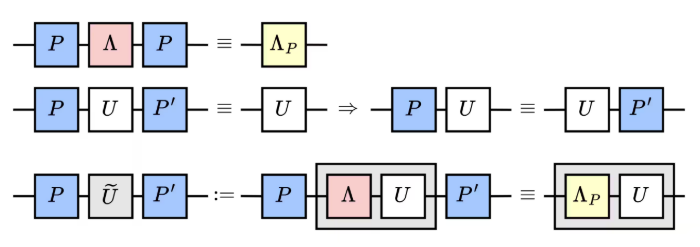

Since most of the errors in current quanutm hardware come from two-qubit gates, this technique is often applied exclusively to (native) two-qubit gates. The following diagram depicts some Pauli twirls for the CNOT and ECR gates. Every circuit within a row has the same ideal effect  

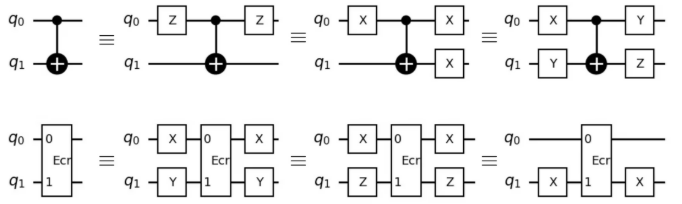

Pauli twirling can be enabled by setting ```enable_gates``` to ```True``` in the twirling options.
* ```num_randomizations```: The number of circuit instances to draw from the ensemble of twirled circuits.
* ```shots_per_randomization```: The number of shots to sample from each circuit instance.  

The following code cell shows how to enable Pauli twirling and set these options for the estimator.

In [ ]:
estimator = Estimator(mode=backend)
estimator.options.twirling.enable_gates = True
estimator.options.twirling.num_randomizations = 32
estimator.options.twirling.shots_per_randomization = 100

# Twirled readout error extinction (TREX)  
Twirled readout error extinction (TREX) mitigates the effect of measurement errors for the estimation of Pauli observable expectation values. Iti s based on the notion of twirled measurements, which are accomplished by randomly substituting measurement gates by a sequence of (1) a Pauli X gate, (2) a measurement, and (3) calssical bit flip. Just like in standard gate twirling, this sequence is equivalent to a plain measurement in the absence of noise, asdepicted in the following diagram.  

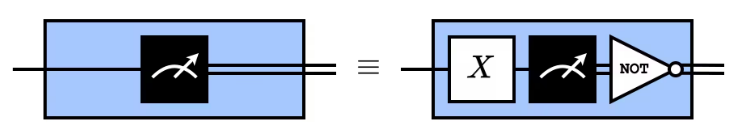  

In the presence of readout error, measurement twirling has the effect of diagonalizing the readout-error transfer matrix, making it easy to invert. Estimating the readout-error transfer matrix requires executing additional calibration circuits, which introduces a small overhead  

TREX can be enabled by setting ```measure_mitigation``` to ```True``` in the Qiskit Runtime resilience options for Estimator. As with gate twirling, you can set the number of circuit randomizations and the number of shots per randomization.  

The following code shows how to enable TREX and set these options for the estimator. None of these options are required to be set explicitly

In [9]:
estimator = Estimator(mode = backend)
estimator.options.resilience.measure_mitigation = True
estimator.options.resilience.measure_noise_learning.num_randomizations = 32
estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

# Zero-noise extrapolation (ZNE)  
While it often improves results, it is not guaranteed to produce an unbiased result.  

ZNE consists of two stages:
1. *Noise amplification*: The original quantum circuit is executed multiple times at different noise rates
2. *Extrapolation*: The ideal result is estimated by extrapolating the noisy expectation value results to the zero-noise limit
 
 Both the noise amplification and extrapolation stages can be implemented in many different ways. Qiskit Runtime implements noise amplification by "digital gate folding" which means that two=qubit gates are replaced with equivalent sequences of the gate and its inverse. For example, replacing a unitary $U$ with $UU^\dagger U $ would yield a noise amplification factor of 3. For the extrapolation, you can choose from one of several functional forms, including a linear fit or an expoenetial fit. The image below depicts digital gate folding on the left, and the extrapolation procedure on the right  

 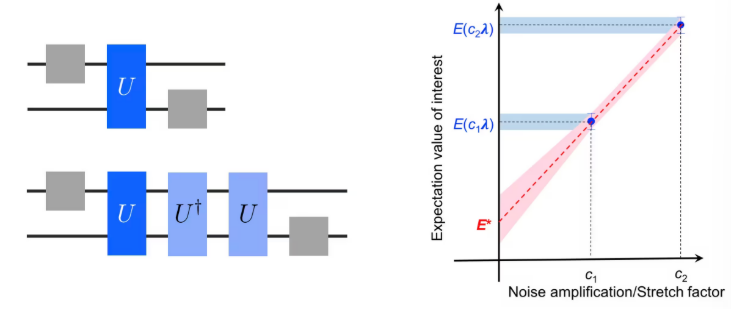

 ZNE can be enabled by setting ```zne_mitigation``` to ```True``` in the Qiskit Runtime resilience options for Estimator. 
 * ```noise_factors```: The noise facotrs to use for noise amplification
 * ```extrapolator``` : The functional form to use for the extrapolation.


In [10]:
estimator = Estimator(backend)
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = [1,3,5]
estimator.options.resilience.zne.extrapolator = 'exponential'

# Probabilistic Error Amplification (PEA)  
PEA is a more sophisticated technique that performs preliminary experiments to reconstruct the noise and then uses this information to perform an accurate amplification. It starts by learning the twirled noise model of each layer of entangling gates in the circuit before they are run (see LayerNoiseLearningOptions for relevant learning options). After the learning phase, the circuits are executed at each noise factor, where every entangling layer of the circuits is amplified by probabilistically injecting single-qubit noise proportional to the corresponding learned noise model. See the article "Evidence for the utility of quantum computing before fault tolerance" for more details.  

PEA consists of three stages:
1. *Learning*: The twirled noise model of each layer of entanlging gates in the circuit is learned
2. *Noise amplification*: The original quantum circuit is executed mmultiple times at different noise factors.
3. *Extrpolation*: The ideal result is estimated by extrapolating the noisy expectatino value results to the zero-noise limit.  

For utility-scale experiments, PEA is often the best choice.

Because PEA is a ZNE noist amplification technique, you alos need to enable ZNE. PEA requires a noise model, which is automatically generated when using primitives.


In [11]:
estimator = Estimator(mode=backend)
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.amplifier = "pea"

# Probabilistic error cancellation (PEC)  
PEC is a techinque for mitigating errors in estimating expectation values. Unlike ZNE, it returns an **unbiased** estimates of the expectation value. However, it generalyy incurs a greater overhead.  

In PEC, the effect of an ideal target circuit is expressed as a linear combination of noisy circuits that are actually implementable in pratice:

$$O_ieal = \sum_{i}{\eta_i O_{noisy,i}}$$

The output of the ideal circuit can then be reproduced by executing different noisy circuit instances drawn from a random ensemble defined by the linear combination. If the coefficients $\eta_i$ form a probability distribution, they can be used directly as the probabilities of the ensemble. In practive, some of the coefficients are negative, so they form a quasi-probability distribution istead. They can still be used to define a random ensemble, but there is a sampling overhead related to the negativity of the quasi-probability distribution, which is characterized by the quantity  

$$\gamma = \sum_{i}{|\eta_i|} >= 1$$

The sampling overhead is a multiplicate factor on the number of shots required to estimate an expectatino value ot a given precision, compared to the number of shots that would be needed from the ideal circuit. It scales quadratically with $\gamma$, which in turn scales exponentially with the depth of the circuit  

PEC can be enabled by setting ```pec_mitigation``` to ```True``` in the Qiskit Runtime resilience options for Estimator. A limit on the sampling overhead can be set using the ```max_overhead``` option.Note that limiting the sampling overhead can cause the precision of the result to excced the requested precision. The default value of ```max_overhead``` is 100

In [ ]:
estimator = Estimator(backend)
estimator.options.resilience.pec_mitigation = True
estimator.options.resilience.pec.max_overhead = 100